In [1]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

In [2]:
dataset = pd.read_csv('./datasets/final_dataset.csv')
dataset = dataset.drop(columns=['Unnamed: 0'])

Text(0, 0.5, '# blocks')

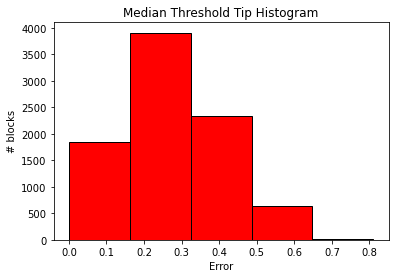

In [3]:
plt.hist(dataset['median_tip'], bins = 5, color = 'red', edgecolor = 'black')
plt.title('Median Threshold Tip Histogram')
plt.xlabel('Error')
plt.ylabel('# blocks')

In [4]:
dataset

,base_fee,timestamp,blocks,gas_limit,gas_used,legacy_tx,sum_priority_fee_eth,tx,median_tip,q1_tip,...,mfers_sales_count,deadfellaz_floor_usd,deadfellaz_volume_usd,deadfellaz_sales_count,beeple_floor_usd,beeple_volume_usd,beeple_sales_count,clonex_floor_usd,clonex_volume_usd,clonex_sales_count
0,47.703934,2021-08-05 12:00:00,108,3187808029,2154963245,19619,36.405995,19976,0.296145,0.165969,...,0,0.0000,0.000000,0,0.0000,0.0,0,0.0000,0.00000,0
1,207.615140,2021-08-05 13:00:00,243,6910676231,3722322759,40617,66.263737,41797,0.318663,0.185114,...,0,0.0000,0.000000,0,0.0000,0.0,0,0.0000,0.00000,0
2,304.282774,2021-08-05 14:00:00,277,7698145312,3982474440,45948,82.869445,46939,0.505857,0.234593,...,0,0.0000,0.000000,0,0.0000,0.0,0,0.0000,0.00000,0
3,225.608906,2021-08-05 15:00:00,254,7075245729,3665086336,47237,64.957738,48827,0.221217,0.104981,...,0,0.0000,0.000000,0,0.0000,0.0,0,0.0000,0.00000,0
4,265.225009,2021-08-05 16:00:00,254,7107208896,3742906764,47726,80.700634,48625,0.391439,0.179006,...,0,0.0000,0.000000,0,0.0000,0.0,0,0.0000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,35.935752,2022-08-05 08:00:00,261,7827886307,4088857563,8684,13.980088,50513,0.184175,0.069670,...,41,1369.6116,29971.993278,18,28941.1975,0.0,0,11397.1251,313807.36638,19
8757,27.898762,2022-08-05 09:00:00,262,7859908518,4130183041,8863,15.294690,54094,0.162364,0.110703,...,41,1369.6116,29971.993278,18,28941.1975,0.0,0,11397.1251,313807.36638,19
8758,23.378548,2022-08-05 10:00:00,257,7710993163,4051538305,9403,18.812820,53906,0.156575,0.103242,...,41,1369.6116,29971.993278,18,28941.1975,0.0,0,11397.1251,313807.36638,19
8759,56.087637,2022-08-05 11:00:00,260,7799821832,4441484858,11701,22.762670,60688,0.236753,0.119655,...,41,1369.6116,29971.993278,18,28941.1975,0.0,0,11397.1251,313807.36638,19


In [5]:
dataset = dataset.drop(columns=['timestamp','fng_classification','date'])

dataset.columns

Index(['base_fee', 'blocks', 'gas_limit', 'gas_used', 'legacy_tx',
       'sum_priority_fee_eth', 'tx', 'median_tip', 'q1_tip', 'q3_tip',
       'eth_price', 'fng_value', 'ethereum_tvl', 'polygon_tvl', 'bsc_tvl',
       'polygon_base_fee', 'polygon_blocks', 'polygon_gas_limit',
       'polygon_gas_used', 'polygon_legacy_tx', 'polygon_sum_priority_fee_eth',
       'polygon_tx', 'polygon_median_tip', 'polygon_q1_tip', 'polygon_q3_tip',
       'bsc_blocks', 'bsc_gas_limit', 'bsc_gas_used',
       'bsc_hourly_median_fee_tx', 'bsc_tx', 'bayc_floor_usd',
       'bayc_volume_usd', 'bayc_sales_count', 'cp_floor_usd', 'cp_volume_usd',
       'cp_sales_count', 'mayc_floor_usd', 'mayc_volume_usd',
       'mayc_sales_count', 'agp_floor_usd', 'agp_volume_usd',
       'agp_sales_count', 'csabc_floor_usd', 'csabc_volume_usd',
       'csabc_sales_count', 'fabc_floor_usd', 'fabc_volume_usd',
       'fabc_sales_count', 'azuki_floor_usd', 'azuki_volume_usd',
       'azuki_sales_count', 'mbirds_floor_usd'

In [6]:
def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    columns = ds.columns
    for i in range (1,n+1):
        for column in columns:
            if column != 'median_tip':
                ds[column+'_'+str(i)] = np.nan

 

    for i in range (1,n+1):        
        for column in columns:
            if column != 'median_tip':
                ds[column+'_'+str(i)] = ds[column].shift(i)
            
    return ds

dataset_n1 = reorder_dataset(dataset,1)
dataset_n3 = reorder_dataset(dataset,3)
dataset_n5 = reorder_dataset(dataset,5)
dataset_n10 = reorder_dataset(dataset,10)
dataset_n24 = reorder_dataset(dataset,24)

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_6588/3016634127.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[column+'_'+str(i)] = np.nan


In [7]:
columns = [x for x in dataset.columns if x != 'median_tip']

dataset_n1 = dataset_n1.drop(columns = columns)

dataset_n3 = dataset_n3.drop(columns = columns)

dataset_n5 = dataset_n5.drop(columns = columns)

dataset_n10 = dataset_n10.drop(columns = columns)

dataset_n24 = dataset_n24.drop(columns = columns)

In [8]:
#### Drop blocks without full history ####
dataset_n1 = dataset_n1.dropna()
dataset_n3 = dataset_n3.dropna()
dataset_n5 = dataset_n5.dropna()
dataset_n10 = dataset_n10.dropna()
dataset_n24 = dataset_n24.dropna()

In [9]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 20, num = 10)]
learning_rate = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 5)]
colsample_bytree = [0.4,0.5,0.6,0.7]
random_grid = {'xg__n_estimators': n_estimators,
               'xg__max_depth': max_depth,
               'xg__learning_rate': learning_rate,
               'xg__colsample_bytree': colsample_bytree}
print(random_grid)

best_metric = -100
best_N = 0

steps = [('scaler', StandardScaler()), ('xg', XGBRegressor())]
pipeline = Pipeline(steps)

N = [1,3,5,10,24]
xg_results = []

for n in N:
    
    if n == 1:
        xg_df = dataset_n1
    elif n ==3:
        xg_df = dataset_n3
    elif n ==5:
        xg_df = dataset_n5
    elif n ==10:
        xg_df = dataset_n10
    elif n ==24:
        xg_df = dataset_n24



    X = xg_df.drop('median_tip', axis=1)
    y = xg_df['median_tip']
    tscv = TimeSeriesSplit(n_splits=3, test_size=math.floor(len(xg_df)*0.1), gap=n)
    xg_bayes = BayesSearchCV(pipeline, random_grid, n_iter = 10, cv = tscv, verbose=10, random_state=42, n_jobs = -1, scoring="neg_mean_absolute_error")
    xg_bayes.fit(X, y)
    print(n)
    print(xg_bayes.best_estimator_)
    print(xg_bayes.best_score_)
    xg_results.append(xg_bayes)
    if best_metric < xg_bayes.best_score_:
        xg = xg_bayes
        xg_specs = xg_bayes.best_estimator_[1]
        best_metric = xg_bayes.best_score_
        best_N = n
print("Best N and model: ", best_N, xg_bayes.best_estimator_[1])
print("Best metric: ", best_metric)

{'xg__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'xg__max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 20], 'xg__learning_rate': [0.1, 0.325, 0.55, 0.775, 1.0], 'xg__colsample_bytree': [0.4, 0.5, 0.6, 0.7]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg__n_estimators=800
[CV 2/3; 1/1] START xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg__n_estimators=800
[CV 3/3; 1/1] START xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg__n_estimators=800
[CV 1/3; 1/1] END xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg__n_estimators=800;, score=-0.141 total time=   3.8s
[CV 2/3; 1/1] END xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg__n_estimators=800;, score=-0.068 total time=   4.3s
[CV 3/3; 1/1] END xg__colsample_bytree=0.5, xg__learning_rate=0.775, xg__max_depth=18, xg_

/Users/fer/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400
[CV 2/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400
[CV 1/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.084 total time=  33.8s
[CV 2/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.056 total time=  38.8s
[CV 3/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.058 total time=  44.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_depth=11, xg__n_estimators=600[CV 2/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_depth=11, xg__n_estimators=600

[CV 1/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_de

/Users/fer/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400
[CV 2/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400
[CV 1/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.109 total time= 1.1min
[CV 2/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.064 total time= 1.3min
[CV 3/3; 1/1] END xg__colsample_bytree=0.6, xg__learning_rate=0.55, xg__max_depth=15, xg__n_estimators=1400;, score=-0.056 total time= 1.4min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_depth=11, xg__n_estimators=600
[CV 3/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_depth=11, xg__n_estimators=600
[CV 1/3; 1/1] START xg__colsample_bytree=0.6, xg__learning_rate=1.0, xg__max_de

In [10]:
best_metric

-0.06319906408360053

In [11]:
best_N

5

In [12]:
if best_N == 1:
    training = dataset_n1
    xg_final = xg_results[0]
elif best_N ==3:
    training = dataset_n3
    xg_final = xg_results[1]
elif best_N ==5:
    training = dataset_n5
    xg_final = xg_results[2]
elif best_N ==10:
    training = dataset_n10
    xg_final = xg_results[3]
elif best_N ==24:
    training = dataset_n24
    xg_final = xg_results[4]


X = training.drop('median_tip', axis=1)

In [13]:
xg_final.best_estimator_[1]

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.325, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=15, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

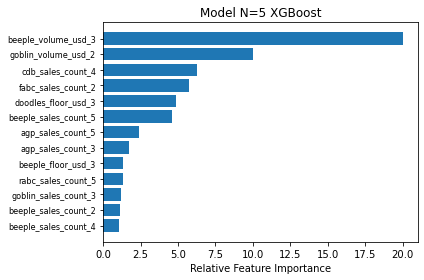

In [14]:
feature_importance = abs(xg_final.best_estimator_[1].feature_importances_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N='+str(best_N)+' XGBoost')

plt.tight_layout()   
plt.show()

In [15]:
#### Real data validation ####
dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation

,base_fee,timestamp,blocks,gas_limit,gas_used,legacy_tx,sum_priority_fee_eth,tx,median_tip,q1_tip,...,mfers_sales_count,deadfellaz_floor_usd,deadfellaz_volume_usd,deadfellaz_sales_count,beeple_floor_usd,beeple_volume_usd,beeple_sales_count,clonex_floor_usd,clonex_volume_usd,clonex_sales_count
0,2.280913,2022-08-07 01:00:00,39,1169764903,688520770,887,1.663079,6582,0.529009,0.168829,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
1,15.432999,2022-08-07 02:00:00,237,7110027747,3880719039,7752,11.868786,45632,0.259681,0.143453,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
2,24.098700,2022-08-07 03:00:00,236,7080964616,3738681213,8183,15.676680,44685,0.213495,0.114983,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
3,20.704683,2022-08-07 04:00:00,259,7770467023,4057887078,10664,27.055056,51861,0.194821,0.118158,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
4,14.718397,2022-08-07 05:00:00,260,7799439368,4218450045,10480,11.841531,51113,0.168015,0.102764,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,72.111645,2022-09-01 02:00:00,262,7860700504,4377071552,6209,17.266260,45688,0.260117,0.149365,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
602,61.364488,2022-09-01 03:00:00,245,7350614227,3984931896,8060,17.113234,48005,0.204441,0.128885,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
603,45.194583,2022-09-01 04:00:00,241,7230584402,3824712180,8929,14.133103,40814,0.222156,0.109491,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
604,39.157729,2022-09-01 05:00:00,261,7831988695,4187495091,7087,15.891177,40512,0.241508,0.128553,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38


In [16]:
dataset_validation = dataset_validation.drop(columns=['timestamp','fng_classification','date'])
columns = [x for x in dataset_validation.columns if x != 'median_tip']

n=best_N
dataset_validation = reorder_dataset(dataset_validation,n)
dataset_validation = dataset_validation.drop(columns = columns)

dataset_validation = dataset_validation.dropna()

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_6588/3016634127.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[column+'_'+str(i)] = np.nan


In [17]:
y_validation = dataset_validation['median_tip']
X_validation = dataset_validation.drop('median_tip', axis=1)

y_val_pred_rf = xg_final.predict(X_validation)
y_val_pred_rf = np.maximum(y_val_pred_rf, 0.)

print('mean_absolute_error XGBoost: ', mean_absolute_error(y_validation, y_val_pred_rf))

mean_absolute_error XGBoost:  0.03468942291588523


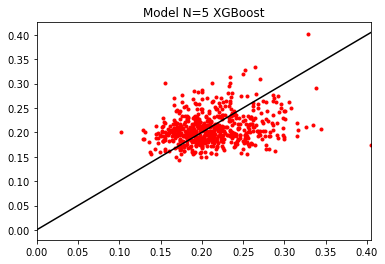

In [18]:
line=np.linspace(0,np.max(y_validation),len(y_validation)) 

plt.plot(y_validation,y_val_pred_rf,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.xlim(0,np.max(y_validation))
plt.title('Model N='+str(best_N)+' XGBoost')


plt.show()

In [19]:
y_val_array = np.array(y_validation)
lower_values=0
for i in range(0,len(y_val_array)):
    if y_val_pred_rf[i] <= y_val_array[i]:
        lower_values=lower_values+1

print("Amount of predicted min tip that wouldn't be enough to go through:" , lower_values)
print("Percetage of predicted min tip that wouldn't be enough to go through: ", (lower_values/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through: 313
Percetage of predicted min tip that wouldn't be enough to go through:  52.079866888519135 %


In [20]:
errors_validation = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_rf[i] - y_val_array[i]) <= 100:
        errors_validation.append(y_val_pred_rf[i] - y_val_array[i])

erros_validation = np.array(errors_validation)

Text(0, 0.5, '# blocks')

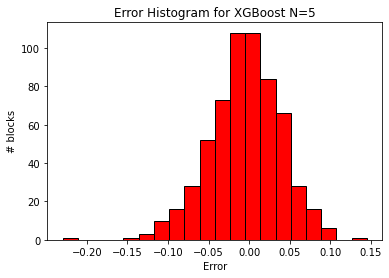

In [21]:
plt.hist(errors_validation, bins = 20, color = 'red', edgecolor = 'black')
#plt.xlim(-2,2)
plt.title('Error Histogram for XGBoost N=' +str(best_N))
plt.xlabel('Error')
plt.ylabel('# blocks')

In [22]:
data = {'real_y': y_val_array, 'xg_y': y_val_pred_rf}
rf_results = pd.DataFrame(data).to_csv("xg_results.csv")